# Iteration 0: Cell to cell type assignment. Cell label = 1867

In [1]:
# Uncomment the line below to show all rows in a pandas dataframe
# import pandas as pd
# pd.set_option('display.max_rows', None)

### This is a notebook demonstrating what happens under the hood in the cell to cell type step in pciSeq

The focus here is on a particular cell (with label 1867) that has 17 gene counts but inside the first iteration the most likely class is the Zero class

![Screenshot_1867.png](Screenshot_1867.png)
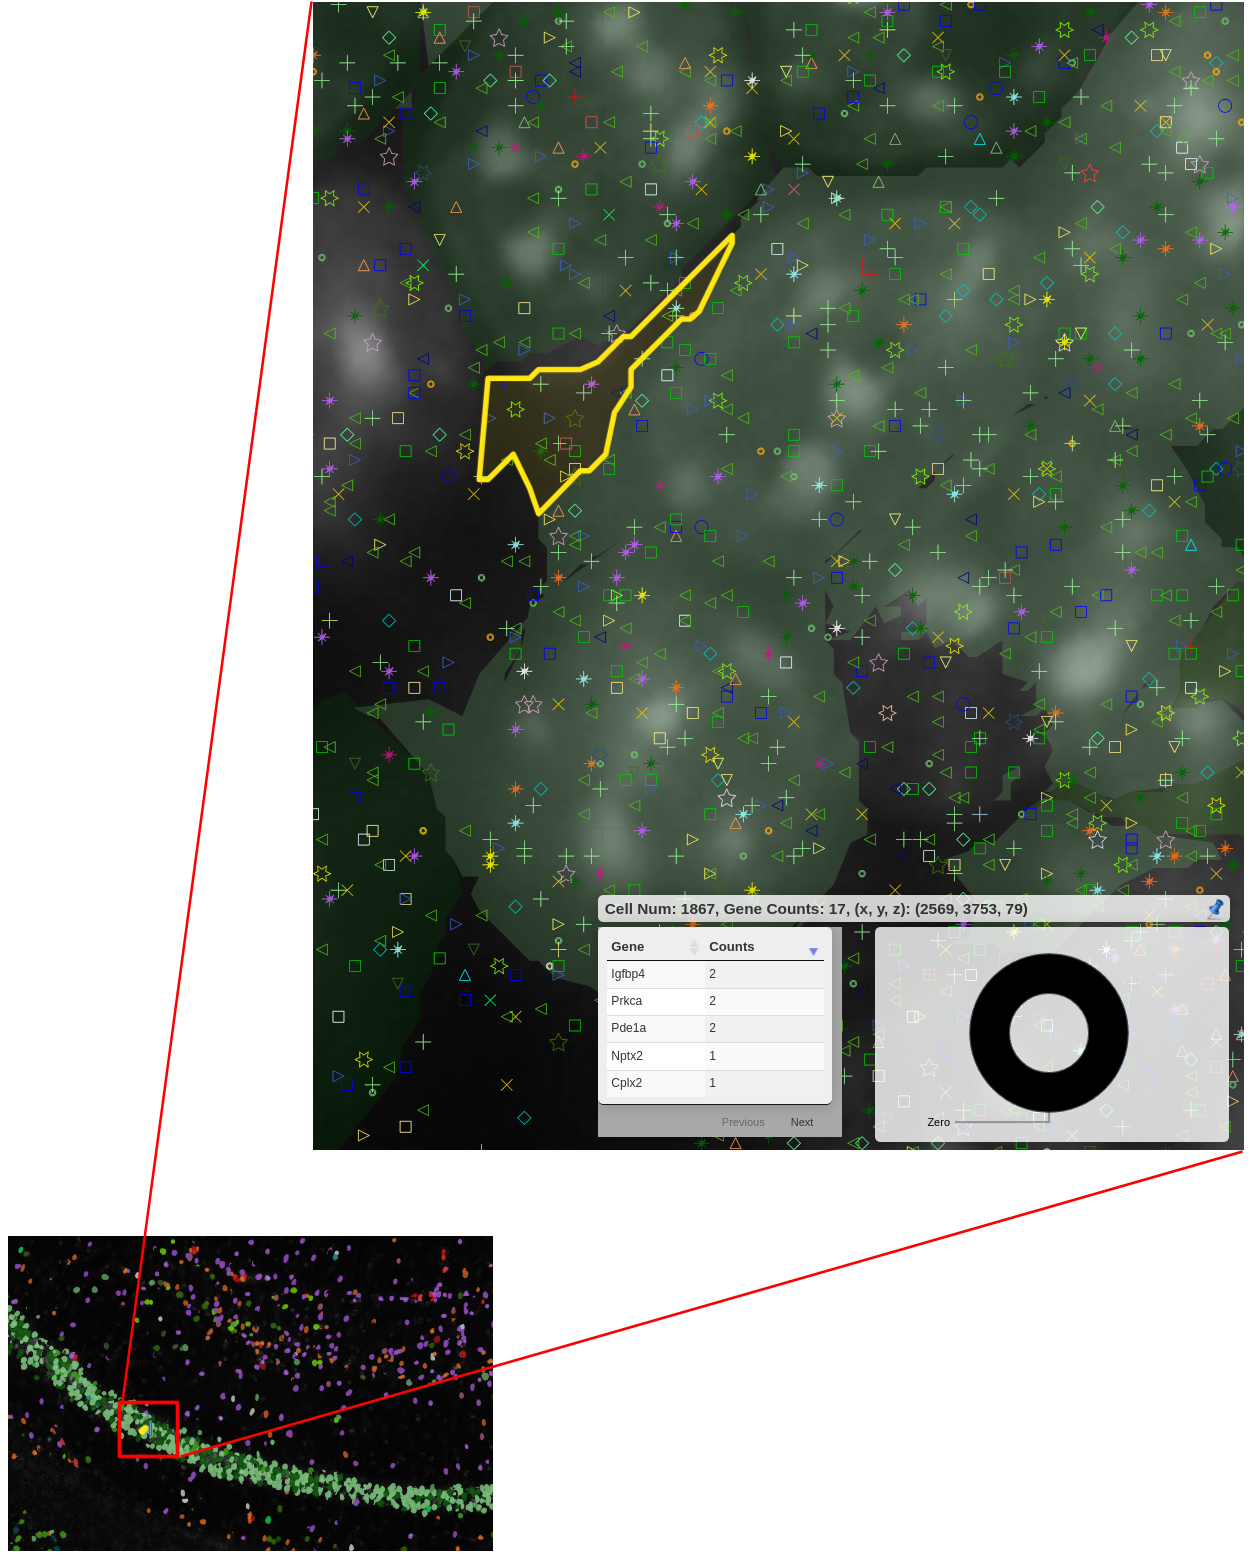

In [2]:
!pip install gdown

In [3]:
import pandas as pd
import numpy as np
import scipy
from scipy.special import softmax
import gdown

In [ ]:
!pip install git+https://github.com/acycliq/pciSeq.git@dev_3d
import pciSeq

  Cloning https://github.com/acycliq/pciSeq.git (to revision dev_3d) to /tmp/pip-req-build-g3bv4vqo
  Running command git clone --filter=blob:none --quiet https://github.com/acycliq/pciSeq.git /tmp/pip-req-build-g3bv4vqo
  Running command git checkout -b dev_3d --track origin/dev_3d
  Switched to a new branch 'dev_3d'
  Branch 'dev_3d' set up to track remote branch 'dev_3d' from 'origin'.
  Resolved https://github.com/acycliq/pciSeq.git to commit 31fd7688f1f848d9e59931636ce39479614ea23d
  Preparing metadata (setup.py) ... -

In [ ]:
file_id = "1wY1PUvAwk_S9MhKbCyB0HzH9oxNloP0M"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
output = "pciSeq.pickle"

In [ ]:
gdown.download(url, output, quiet=False)

In [ ]:
obj = pd.read_pickle(output)

In [ ]:
my_cell = 1867
my_classes = ['TEGLU23', 'TEGLU24', 'TEGLU21', 'Zero']

In [ ]:
# Set the hyperparameters
rSpot = 2.0               # Spread of the negative binomial
SpotReg = 0.1             # Spot regularization: Additive factor applied to the single cell data
inefficiency = 0.2        # multiplicative factor applied to the single cell data

In [ ]:
# Another piece of information comes from the single cell data. For simplicity
# we are pulling here only the gene expressions for 'TEGLU23' (expected in CA3) 
# and 'TEGLU24', 'TEGLU21' (expected in CA3) 
my_class_definitions = obj.single_cell.mean_expression[my_classes]
my_class_definitions

### Part 1. Initialization

In [ ]:
# To set the initial gene counts for any given cell we collect the gene reads inside the cell boundaries
# For cell 10275 these gene reads are the spots below
spots_1867 = obj.spots.data[obj.spots.data.label == my_cell]
spots_1867

In [ ]:
# Hence we aggregate per gene and we derive the gene counts
cgc = spots_1867.groupby('gene_name').size()
cgc

In [ ]:
# the cell has 17 reads inside its boundaries
cgc.sum()

In [ ]:
# The cell gene counts introduced above contain only genes with gene reads > 0.
# We need however the full gene panel
cgc = cgc.reindex(obj.genes.gene_panel, fill_value=0)

In [ ]:
# Note also that the eta (the random variable to model the gene inefficiency) is initialied as a vector of ones with lenght
# equal to the number of genes:
eta_bar = np.ones(obj.nG)

### Part 2. Cell to cell type

In [ ]:
def negative_binomial_loglikelihood(x: np.ndarray, r: float, p: np.ndarray) -> np.ndarray:
    log_likelihood = x * np.log(p) + r * np.log(1 - p)

    return log_likelihood

In [ ]:
# prepare now the data from the negative binomial
ScaledExp = my_class_definitions * inefficiency * eta_bar[:, None]
ScaledExp = ScaledExp + SpotReg
p = ScaledExp / (ScaledExp + rSpot)

In [ ]:
# evaluate the loglikelihood
teglu_contr = negative_binomial_loglikelihood(cgc.values[:, None], rSpot, p.values)
teglu_contr.sum(axis=0)

In [ ]:
# some housekeeping, results look better in a dataframe
teglu_contr_df = pd.DataFrame(teglu_contr, columns=my_classes).set_index(obj.genes.gene_panel)
teglu_contr_df

In [ ]:
# Get the total loglikelihood
teglu_contr_df.sum(axis=0).sort_values(ascending=False)

I seems that the Zero class has the highest loglikelihood

In [ ]:
# Lets now compare the Zero class to TEGLU24 (second best)
my_df = teglu_contr_df[['TEGLU24', 'Zero']]

In [ ]:
# calc the difference between the contributions
diff = teglu_contr_df['TEGLU24'] - teglu_contr_df['Zero']
my_df = my_df.assign(diff = diff)

In [ ]:
# Top 5 genes that are cotributing most for the MFOL1 cell type
my_df.sort_values(by='diff', ascending=False).head(5)

In [ ]:
# Top 5 genes that are cotributing most for the Zero cell type
my_df.sort_values(by='diff', ascending=False).tail(5)

The absence of markers such as Neurod6 is probably what makes cell typing to point towards the Zero class